### First we start by installing all neccessary modules 

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install beautifulsoup4


     |████████████████████████████████| 122kB 3.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lxml


     |████████████████████████████████| 5.5MB 5.5MB/s eta 0:00:01     |█████████████████████▉          | 3.8MB 5.5MB/s eta 0:00:010:01
Note: you may need to restart the kernel to use updated packages.


### Download necessary packages 

In [4]:
import numpy as np # library to handle data 
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from pandas.io.html import read_html
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml

print('Libraries imported Sibusiso.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

### Get postal codes and suburbs & read table by class

In [5]:
website_url = 'http://geo.mycyberict.com/south_africa/cape-town/'
ct_table = read_html(website_url, attrs={"class":"table table-bordered table-hover table-striped"})
print("extraxcted table")

extraxcted table


### Verify pandas dataframe

In [95]:
ct_table[0].head()

,Suburb,Zip Code,Postal Code
0,NaN,8000.0,8001.0
1,Athlone,7760.0,7764.0
2,Athlone Industria 1,NaN,7764.0
3,Athlone Industria 2,NaN,7764.0
4,Bakoven,NaN,8005.0


### Table class is table

In [7]:
suburbs = ct_table[0]


In [8]:
type(suburbs)

pandas.core.frame.DataFrame

In [9]:
suburbs.head()

,Suburb,Zip Code,Postal Code
0,NaN,8000.0,8001.0
1,Athlone,7760.0,7764.0
2,Athlone Industria 1,NaN,7764.0
3,Athlone Industria 2,NaN,7764.0
4,Bakoven,NaN,8005.0


In [10]:
for col in suburbs.columns: 
    print(col) 

Suburb
Zip Code
Postal Code


In [11]:
cape_town = suburbs.drop(['Zip Code'], axis=1)
cape_town.head()

,Suburb,Postal Code
0,NaN,8001.0
1,Athlone,7764.0
2,Athlone Industria 1,7764.0
3,Athlone Industria 2,7764.0
4,Bakoven,8005.0


### Assign headers 

### Remone NaN values


In [12]:
ct_clean = cape_town.dropna(axis=0,how='any')
ct_clean.tail()

,Suburb,Postal Code
173,Waterfront,8001.0
174,Westlake,7945.0
175,Woodstock,7925.0
176,Wynberg,7800.0
177,Ysterplaat,7405.0


### add Cape town as City for geocoding

In [13]:
ct_clean['City']='Cape town'
ct_clean.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Suburb,Postal Code,City
1,Athlone,7764.0,Cape town
2,Athlone Industria 1,7764.0,Cape town
3,Athlone Industria 2,7764.0,Cape town
4,Bakoven,8005.0,Cape town
5,Bantry BAY,8005.0,Cape town


In [14]:
suburb_city = ct_clean.drop(['Postal Code'], axis=1)
suburb_city.head()

,Suburb,City
1,Athlone,Cape town
2,Athlone Industria 1,Cape town
3,Athlone Industria 2,Cape town
4,Bakoven,Cape town
5,Bantry BAY,Cape town


## Combine for address 

In [15]:
suburb_city['address'] = suburb_city['Suburb'].str.cat(suburb_city['City'],sep=" ")


In [16]:
suburb_city.head()

,Suburb,City,address
1,Athlone,Cape town,Athlone Cape town
2,Athlone Industria 1,Cape town,Athlone Industria 1 Cape town
3,Athlone Industria 2,Cape town,Athlone Industria 2 Cape town
4,Bakoven,Cape town,Bakoven Cape town
5,Bantry BAY,Cape town,Bantry BAY Cape town


### Obtain latitude & longitude from address colomns 

In [17]:
locator = Nominatim(user_agent="ct_explorer")

from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
suburb_city['location'] = suburb_city['address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
suburb_city['point'] = suburb_city['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
suburb_city[['latitude', 'longitude', 'altitude']] = pd.DataFrame(suburb_city['point'].tolist(), index=suburb_city.index)

In [18]:
suburb_city.head()

,Suburb,City,address,location,point,latitude,longitude,altitude
1,Athlone,Cape town,Athlone Cape town,"(Athlone, Cape Town, City of Cape Town, Wester...","(-33.9666667, 18.505, 0.0)",-33.966667,18.505000,0.0
2,Athlone Industria 1,Cape town,Athlone Industria 1 Cape town,"(Athlone Street, Gants Inustrial Area, Cape To...","(-34.0996602, 18.8438343, 0.0)",-34.099660,18.843834,0.0
3,Athlone Industria 2,Cape town,Athlone Industria 2 Cape town,None,None,NaN,NaN,NaN
4,Bakoven,Cape town,Bakoven Cape town,"(Bakoven, Cape Town, City of Cape Town, Wester...","(-33.96, 18.3827778, 0.0)",-33.960000,18.382778,0.0
5,Bantry BAY,Cape town,Bantry BAY Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...","(-33.9281512, 18.3789695, 0.0)",-33.928151,18.378970,0.0


In [100]:
ct_geo = suburb_city.drop(['point','altitude','address'], axis=1)

In [101]:
ct_geo.head()

,Suburb,City,location,latitude,longitude
1,Athlone,Cape town,"(Athlone, Cape Town, City of Cape Town, Wester...",-33.966667,18.505000
2,Athlone Industria 1,Cape town,"(Athlone Street, Gants Inustrial Area, Cape To...",-34.099660,18.843834
3,Athlone Industria 2,Cape town,None,NaN,NaN
4,Bakoven,Cape town,"(Bakoven, Cape Town, City of Cape Town, Wester...",-33.960000,18.382778
5,Bantry BAY,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970


In [102]:
ct_geo=ct_geo.dropna(axis=0,how='any')

In [103]:
ct_geo.head()

,Suburb,City,location,latitude,longitude
1,Athlone,Cape town,"(Athlone, Cape Town, City of Cape Town, Wester...",-33.966667,18.505000
2,Athlone Industria 1,Cape town,"(Athlone Street, Gants Inustrial Area, Cape To...",-34.099660,18.843834
4,Bakoven,Cape town,"(Bakoven, Cape Town, City of Cape Town, Wester...",-33.960000,18.382778
5,Bantry BAY,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970
6,Bantrybaai,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970


### obtain Cape Town Geo coordinates

In [104]:
address = 'Cape town'

locator = Nominatim(user_agent="ct_explorer")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cape town are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cape town are -33.928992, 18.417396.


### Geo map of cape town with suburb pointers

In [105]:
# create map of Cape town using latitude and longitude values
map_capetown = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location, suburb in zip(ct_geo['latitude'], ct_geo['longitude'], ct_geo['location'], ct_geo['Suburb']):
    label = '{}, {}'.format(suburb, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_capetown)  
    
map_capetown

### Defining FourSquare Credentials 

In [106]:
CLIENT_ID = 'LFPEUBYUZAMBG555DTYL4INYTH2W0HHWRGXLMGV3AN4CHLK3' # your Foursquare ID
CLIENT_SECRET = 'F50AQVH4RVAYMF333RAEGGIMCR2ZYYNMKRM1LAJUHWUKJX2Q' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Sibusiso:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Sibusiso:
CLIENT_ID: LFPEUBYUZAMBG555DTYL4INYTH2W0HHWRGXLMGV3AN4CHLK3
CLIENT_SECRET:F50AQVH4RVAYMF333RAEGGIMCR2ZYYNMKRM1LAJUHWUKJX2Q


### Function to find coffee café data in Cape town

In [107]:
address = 'Cape town'

locator = Nominatim(user_agent="ct_explorer")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cape town are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cape town are -33.928992, 18.417396.


In [108]:
query = 'coffee'
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 5000 #5km radius around Cape town geo-center 
print(query + ' .... got it!')
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, query, radius, LIMIT)
url


coffee .... got it!


'https://api.foursquare.com/v2/venues/search?client_id=LFPEUBYUZAMBG555DTYL4INYTH2W0HHWRGXLMGV3AN4CHLK3&client_secret=F50AQVH4RVAYMF333RAEGGIMCR2ZYYNMKRM1LAJUHWUKJX2Q&ll=-33.928992,18.417396&v=20180604&query=coffee&radius=5000&limit=200'

In [109]:
### discard below

### Request the json file

In [110]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f4520e2d04dfc25dacfd5f7'},
 'response': {'venues': [{'id': '4fa0c477e4b0c33ec64258bf',
    'name': 'Truth Coffee HQ',
    'location': {'address': '36 Buitenkant St',
     'crossStreet': 'between Barrack & Commercial',
     'lat': -33.92828568736539,
     'lng': 18.4227945872331,
     'labeledLatLngs': [{'label': 'display',
       'lat': -33.92828568736539,
       'lng': 18.4227945872331}],
     'distance': 504,
     'postalCode': '8005',
     'cc': 'ZA',
     'city': 'iKapa',
     'state': 'Western Cape',
     'country': 'iNingizimu Afrika',
     'formattedAddress': ['36 Buitenkant St (between Barrack & Commercial)',
      'iKapa',
      '8005',
      'iNingizimu Afrika']},
    'categories': [{'id': '4bf58dd8d48988d16d941735',
      'name': 'Café',
      'pluralName': 'Cafés',
      'shortName': 'Café',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 

### Assign relevant part

In [111]:
 #from pandas.json import json_normalize

venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)

dataframe.tail()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood,venuePage.id
45,5a53630817556220de4cd864,The Coffee Power Station,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598365970,False,NaN,NaN,-33.906540,18.419436,"[{'label': 'display', 'lat': -33.90654, 'lng':...",2506,8001,ZA,iKapa,Western Cape,iNingizimu Afrika,"[iKapa, 8001, iNingizimu Afrika]",NaN,NaN
46,4f473b00e4b0e132286a1329,Charmi's Coffee House,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598365970,False,NaN,NaN,-33.927316,18.430644,"[{'label': 'display', 'lat': -33.9273156810806...",1237,NaN,ZA,iKapa,Western Cape,iNingizimu Afrika,"[iKapa, iNingizimu Afrika]",NaN,NaN
47,56a92621498ec39c6d1af9f9,Folk Coffee Anthropology,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598365970,False,"Touchstone House, 8 Bree Str",NaN,-33.917535,18.422235,"[{'label': 'display', 'lat': -33.9175347227082...",1351,NaN,ZA,iKapa,Western Cape,iNingizimu Afrika,"[Touchstone House, 8 Bree Str, iKapa, iNingizi...",Cape Town CBD - Foreshore,NaN
48,4dbfcf4f1e72dd48b1f9baa6,Adam's Coffee Garden,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598365970,False,0A Hertzog Blvd,NaN,-33.920785,18.428493,"[{'label': 'display', 'lat': -33.9207851984073...",1373,NaN,ZA,iKapa,Western Cape,iNingizimu Afrika,"[0A Hertzog Blvd, iKapa, iNingizimu Afrika]",NaN,NaN
49,5ab91b5cda5e56267a4635a0,August Coffee,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1598365970,False,NaN,NaN,-33.917156,18.413270,"[{'label': 'display', 'lat': -33.917156, 'lng'...",1371,8001,ZA,iKapa,Western Cape,iNingizimu Afrika,"[iKapa, 8001, iNingizimu Afrika]",NaN,NaN


### Extract what we need

In [112]:
cof_df = dataframe[['id', 'name', 'location.lat', 'location.lng', 'location.formattedAddress']]
cof_df.head()

,id,name,location.lat,location.lng,location.formattedAddress
0,4fa0c477e4b0c33ec64258bf,Truth Coffee HQ,-33.928286,18.422795,[36 Buitenkant St (between Barrack & Commercia...
1,4fd6e4d3e4b0b5d98983a754,Seattle Coffee Company,-33.925483,18.412742,"[iKapa, iNingizimu Afrika]"
2,503f07b8e4b0f8feebc0906b,W Café Coffee Bar,-33.922135,18.422479,"[Woolworths Adderley St, iKapa, iNingizimu Afr..."
3,4c4ebabbf53d0f47c37dfea6,Seattle Coffee Company,-33.918117,18.422749,"[4 Loop St (Hans Strijdom Ave), iKapa, 8001, i..."
4,4f69f27fe4b010659195f4cb,Seattle Coffee Company,-33.917916,18.427897,"[Caltex Waterfront, iKapa, iNingizimu Afrika]"


In [113]:
cof_df.rename(columns = {'location.lat':'lat','location.lng':'lng'}, inplace = True)
cof_df.tail()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,name,lat,lng,location.formattedAddress
45,5a53630817556220de4cd864,The Coffee Power Station,-33.906540,18.419436,"[iKapa, 8001, iNingizimu Afrika]"
46,4f473b00e4b0e132286a1329,Charmi's Coffee House,-33.927316,18.430644,"[iKapa, iNingizimu Afrika]"
47,56a92621498ec39c6d1af9f9,Folk Coffee Anthropology,-33.917535,18.422235,"[Touchstone House, 8 Bree Str, iKapa, iNingizi..."
48,4dbfcf4f1e72dd48b1f9baa6,Adam's Coffee Garden,-33.920785,18.428493,"[0A Hertzog Blvd, iKapa, iNingizimu Afrika]"
49,5ab91b5cda5e56267a4635a0,August Coffee,-33.917156,18.413270,"[iKapa, 8001, iNingizimu Afrika]"


In [114]:
shop=cof_df
type(shop)

pandas.core.frame.DataFrame

### Visualize and assess the the locations

In [115]:
address = 'Cape town'

locator = Nominatim(user_agent="ct_explorer")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cape town are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cape town are -33.928992, 18.417396.


In [116]:
map_caf = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around the Cape town

    
# add a red circle marker to represent the Cape town centre 
folium.features.CircleMarker(
    [latitude, longitude],
    radius=5,
    color='red',
    popup='Cape town',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_caf)

# add the coffee café as brown circle markers
for lat, lng, name in zip(shop.lat, shop.lng, shop.name):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)    
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_caf) 

# display map
map_caf


### KMeans clustering for location 

In [123]:
kclusters = 3

ct_clustering = ct_geo.drop('Suburb',1)
ct_clustering.head()

,City,location,latitude,longitude
1,Cape town,"(Athlone, Cape Town, City of Cape Town, Wester...",-33.966667,18.505000
2,Cape town,"(Athlone Street, Gants Inustrial Area, Cape To...",-34.099660,18.843834
4,Cape town,"(Bakoven, Cape Town, City of Cape Town, Wester...",-33.960000,18.382778
5,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970
6,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970


In [124]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ct_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:177]

ValueError: setting an array element with a sequence.

### Clustering results 

In [125]:
indentified_clusters = kmeans.fit_predict(ct_clustering)
indentified_clusters

ValueError: setting an array element with a sequence.

In [126]:
data_with_clusters = ct_clustering
data_with_clusters['Cluster']=indentified_clusters
data_with_clusters

,City,location,latitude,longitude,Cluster
1,Cape town,"(Athlone, Cape Town, City of Cape Town, Wester...",-33.966667,18.505000,0
2,Cape town,"(Athlone Street, Gants Inustrial Area, Cape To...",-34.099660,18.843834,0
4,Cape town,"(Bakoven, Cape Town, City of Cape Town, Wester...",-33.960000,18.382778,0
5,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970,0
6,Cape town,"(Bantry Bay, Cape Town, City of Cape Town, Wes...",-33.928151,18.378970,0
7,Cape town,"(Belhar, Cape Town, City of Cape Town, Western...",-33.944722,18.625833,0
8,Cape town,"(Bellville, City of Cape Town, Western Cape, S...",-33.883733,18.636870,0
9,Cape town,"(Bergvliet, Cape Town, City of Cape Town, West...",-34.044796,18.452832,0
10,Cape town,"(Bo-Kaap, Chiappini Lane, Schotsche Kloof, Cap...",-33.921094,18.414100,0
11,Cape town,"(Bothasig, Cape Town, City of Cape Town, Weste...",-33.859444,18.541111,0


In [127]:
import matplotlib as plt
import matplotlib.pyplot as plt
print("got it!")

got it!


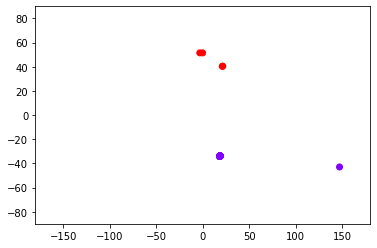

In [128]:
plt.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Cluster'],cmap='rainbow')
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.show()

In [82]:
data_with_clusters.head(10)

,latitude,longitude,Cluster
1,-33.966667,18.505000,0
2,-34.099660,18.843834,0
4,-33.960000,18.382778,0
5,-33.928151,18.378970,0
6,-33.928151,18.378970,0
7,-33.944722,18.625833,0
8,-33.883733,18.636870,0
9,-34.044796,18.452832,0
10,-33.921094,18.414100,0
11,-33.859444,18.541111,0


### Elbow Method to determine best number of suburb Clusters

In [83]:
kmeans.inertia_

17133.446721441866

In [91]:
wcss=[]
for i in range(1,10):
    kmeans=KMeans(i)
    kmeans.fit(data_with_clusters)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

In [92]:
wcss

[42225.229252428435,
 17133.44672144187,
 655.0260662172277,
 6.0048993072814465,
 1.549265987040269,
 1.0269639868628493,
 0.7844027074509725,
 0.5818794983284246,
 0.4603555488831567]

Text(0, 0.5, 'within-cluster Sum of Squares')

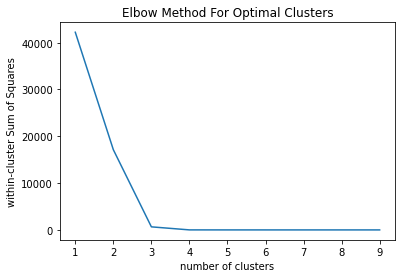

In [94]:
number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('number of clusters')
plt.ylabel('within-cluster Sum of Squares')